In [1]:
import string

import dask.diagnostics
import fsspec
import fv3fit
import proplot
import vcm.catalog
import xarray as xr

import cloud
import plotting
import times

from metrics import compute_spatial_metrics, compute_spatial_weights

/home/spencerc/miniconda3/envs/fv3net-makefile/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
plotting.configure_style()

In [3]:
MODEL = "gs://vcm-ml-experiments/spencerc/2022-06-20-nudge-to-25-km-ml-models/fluxes-rf-transmissivity-snoalb-derived"
DATA = "gs://vcm-ml-experiments/spencerc/2022-06-28/n2f-25km-tapered-25-snoalb-nudging-tendencies-and-fluxes.zarr"
FINE_RES = {
    "Minus 4 K": "gs://vcm-ml-raw-flexible-retention/2021-01-04-1-year-C384-FV3GFS-simulations/minus-4K/C384-to-C48-diagnostics",
    "Unperturbed": "gs://vcm-ml-raw-flexible-retention/2021-01-04-1-year-C384-FV3GFS-simulations/unperturbed/C384-to-C48-diagnostics",
    "Plus 4 K": "gs://vcm-ml-raw-flexible-retention/2021-01-04-1-year-C384-FV3GFS-simulations/plus-4K/C384-to-C48-diagnostics",
    "Plus 8 K": "gs://vcm-ml-raw-flexible-retention/2022-06-02-two-year-C384-FV3GFS-simulations/plus-8K/C384-to-C48-diagnostics",
}
INPUT_VARIABLES = [
    "air_temperature",
    "specific_humidity",
    "land_sea_mask",
    "surface_diffused_shortwave_albedo",
    "surface_geopotential",
    "cos_zenith_angle",
    "total_sky_downward_shortwave_flux_at_top_of_atmosphere"
]

TIMESTEPS_FILE = "../workflows/ml-training/test.json"

In [4]:
test_times = times.open_times(TIMESTEPS_FILE)
model = fv3fit.load(MODEL)

In [5]:
def open_inputs(test_times, variables):
    ds = xr.open_zarr(fsspec.get_mapper(DATA)).sel(time=test_times)
    grid = vcm.catalog.catalog["grid/c48"].to_dask().load()
    toa_downward_shortwave = cloud.open_tape_sequence(FINE_RES, "gfsphysics_15min_coarse", concat_dim="dataset").DSWRFtoa
    toa_downward_shortwave = toa_downward_shortwave.sel(time=test_times)
    toa_downward_shortwave = toa_downward_shortwave.rename("total_sky_downward_shortwave_flux_at_top_of_atmosphere")
    ds = ds.merge(toa_downward_shortwave)
    ds = ds.assign(cos_zenith_angle=vcm.cos_zenith_angle(ds.time, grid.lon, grid.lat))
    return ds[variables].unify_chunks()


def open_targets(test_times):
    targets = cloud.open_tape_sequence(FINE_RES, "gfsphysics_15min_coarse", concat_dim="dataset")[["DSWRFsfc", "USWRFsfc", "DLWRFsfc"]]
    targets["NSWRFsfc"] = targets.DSWRFsfc - targets.USWRFsfc
    targets = targets.rename(
        {
            "DSWRFsfc": "downward_shortwave_sfc_flux_via_transmissivity",
            "NSWRFsfc": "net_shortwave_sfc_flux_via_transmissivity",
            "DLWRFsfc": "override_for_time_adjusted_total_sky_downward_longwave_flux_at_surface"
        }
    )
    return targets.sel(time=test_times).drop("USWRFsfc").unify_chunks()

In [6]:
def _predict_kernel(ds, model, template_dims, drop_vars):
    return model.predict(ds).transpose(*template_dims).drop(drop_vars)


def predict(ds, model, template, drop_vars):
    """A dask-compatible version of model.predict"""
    return xr.map_blocks(
        _predict_kernel,
        ds,
        args=(model, template.dims, drop_vars),
        template=template
    )

In [7]:
inputs = open_inputs(test_times, INPUT_VARIABLES)
targets = open_targets(test_times)

In [8]:
template = targets  # Needed for xr.map_blocks (not used or anything but output dataset structure)

In [9]:
predictions = predict(inputs, model, template, ["shortwave_transmissivity_of_atmospheric_column"])
bias = predictions - targets

In [10]:
with dask.diagnostics.ProgressBar():
    mean_bias = bias.mean("time").compute()

weights = compute_spatial_weights()
metrics = compute_spatial_metrics(mean_bias, weights)

[########################################] | 100% Completed |  6min 48.8s


In [11]:
metrics.sel(metric="rmse", region="global")

<xarray.Dataset>
Dimensions:                                                                 (dataset: 4)
Coordinates:
  * dataset                                                                 (dataset) object ...
    region                                                                  <U6 ...
    metric                                                                  <U4 ...
Data variables:
    downward_shortwave_sfc_flux_via_transmissivity                          (dataset) float32 ...
    override_for_time_adjusted_total_sky_downward_longwave_flux_at_surface  (dataset) float32 ...
    net_shortwave_sfc_flux_via_transmissivity                               (dataset) float32 ...

In [12]:
metrics.sel(metric="rmse", region="land")

<xarray.Dataset>
Dimensions:                                                                 (dataset: 4)
Coordinates:
  * dataset                                                                 (dataset) object ...
    region                                                                  <U4 ...
    metric                                                                  <U4 ...
Data variables:
    downward_shortwave_sfc_flux_via_transmissivity                          (dataset) float32 ...
    override_for_time_adjusted_total_sky_downward_longwave_flux_at_surface  (dataset) float32 ...
    net_shortwave_sfc_flux_via_transmissivity                               (dataset) float32 ...

In [13]:
with dask.diagnostics.ProgressBar():
    mean_bias = bias.sel(dataset="Unperturbed").mean("time").compute()

[########################################] | 100% Completed |  1min 37.6s


In [14]:
weights = compute_spatial_weights()
metrics = compute_spatial_metrics(mean_bias, weights)

In [15]:
def title_metrics(metrics, variable):
    m = metrics[variable]
    lm = m.sel(metric="mean", region="land").item()
    lr = m.sel(metric="rmse", region="land").item()
    osm = m.sel(metric="mean", region="ocean/sea-ice").item()
    osr = m.sel(metric="rmse", region="ocean/sea-ice").item()
    return f"Land: {lm:0.1f}, {lr:0.1f}\nOcean/sea-ice: {osm:0.1f}, {osr:0.1f}"

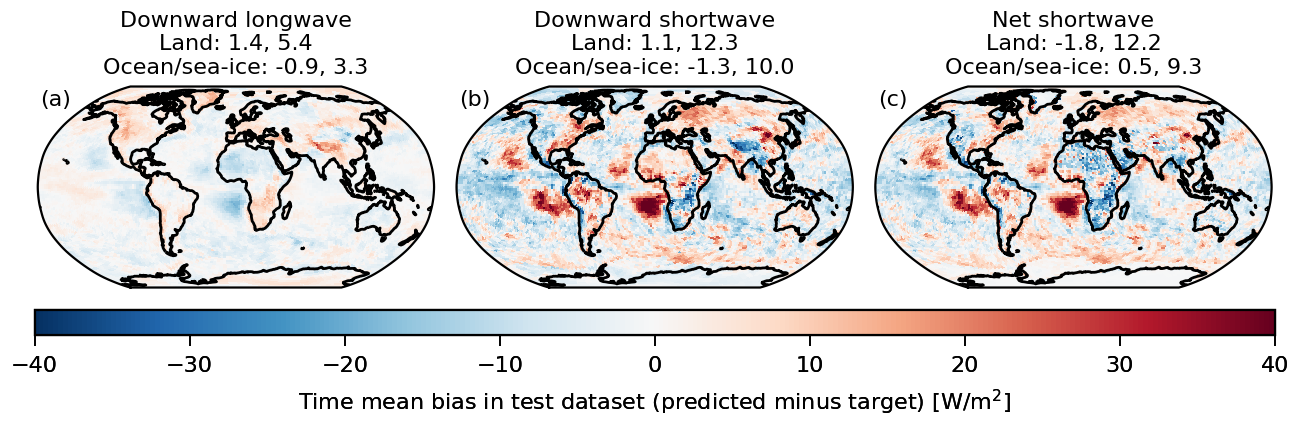

In [16]:
fig, (ax1, ax2, ax3) = proplot.subplots(ncols=3, nrows=1, figwidth=6.5, refaspect=2., proj="robin")
VARIABLES = [
    "override_for_time_adjusted_total_sky_downward_longwave_flux_at_surface",
    "downward_shortwave_sfc_flux_via_transmissivity",
    "net_shortwave_sfc_flux_via_transmissivity"
]
SHORT_NAMES = {
    "override_for_time_adjusted_total_sky_downward_longwave_flux_at_surface": "Downward longwave",
    "downward_shortwave_sfc_flux_via_transmissivity": "Downward shortwave",
    "net_shortwave_sfc_flux_via_transmissivity": "Net shortwave"
}

for ax, variable in zip([ax1, ax2, ax3], VARIABLES):
    p = plotting.plot_map(ax, mean_bias, variable, -40, 40, discrete=False)
    m = title_metrics(metrics, variable)
    ax.set_title(f"{SHORT_NAMES[variable]}\n{m}")

fig.colorbar(p, loc="bottom", label="Time mean bias in test dataset (predicted minus target) [W/m$^2$]", width=0.125)

for ax, label in zip((ax1, ax2, ax3), string.ascii_lowercase):
    ax.annotate(f"({label})", xy=(0, 1), xytext=(1, -1), va="top", xycoords="axes fraction", textcoords="offset points")

fig.savefig("figures/figure-07.png", dpi=200)
fig.savefig("figures/figure-07.pdf")